In [137]:
import pandas as pd
import datetime as dt

In [138]:
df = pd.read_csv('DesMoines_GDD_PredictedGDD.csv')
from datetime import datetime
import time
def convert_date_string(date_str):
    time_struct = time.strptime(date_str, '%m/%d/%y')
    dt_obj = datetime(*time_struct[:6])
    new_date_str = dt_obj.strftime('%m/%d/%y')
    return new_date_str
df['Date'] = df['Date'].apply(lambda x: convert_date_string(x))

In [139]:
corn = pd.read_excel('commodity_prices.xlsx', sheet_name='C 1 (Corn)')[['Date','Last Price']]
corn.rename(columns={'Last Price':'Corn'}, inplace=True)
def converter(s):
    parts = s.split()
    integer_part = int(parts[0])
    fraction_part = eval(parts[1])
    result = integer_part + fraction_part
    return result
corn['Corn'] = corn['Corn'].apply(lambda x: converter(x) if ' ' in str(x) else x)
corn['Date'] = corn['Date'].apply(lambda x: str(x))
def convert_date_string(date_str):
    dt_obj = dt.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
    new_date_str = dt_obj.strftime('%m/%d/%y')
    return new_date_str
corn['Date'] = corn['Date'].apply(lambda x: convert_date_string(x))

In [140]:
df = pd.merge(df, corn, on='Date', how='inner')

In [141]:
df['Corn_returns'] = df['Corn'].pct_change()
df['Corn_cumulative_returns'] = (1 + df['Corn_returns']).cumprod()
df['Predicted_GDD_MA'] = df['Predicted GDD'].rolling(10).mean()
df['upper'] = df['Predicted_GDD_MA'] + .5 * df['Predicted GDD'].rolling(10).std()
df['lower'] = df['Predicted_GDD_MA'] - .5 * df['Predicted GDD'].rolling(10).std()
df['correlation'] = df['Corn_returns'].rolling(25).corr(df['Predicted GDD'])
df['signal'] = 0
df.loc[df['Predicted GDD'] > df['upper'], 'signal'] = 1
df.loc[df['Predicted GDD'] < df['lower'], 'signal'] = -1
df.loc[df['correlation'] > 0, 'signal'] = 0
df['signal'] = df['signal'].shift(1)

In [142]:
df['signal returns'] = df['signal'] * df['Corn_returns']
df['signal cumulative returns'] = (1 + df['signal returns']).cumprod()

<AxesSubplot: >

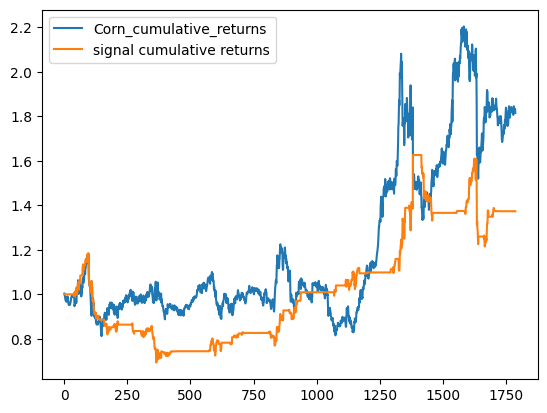

In [143]:
df[['Corn_cumulative_returns', 'signal cumulative returns']].plot()